In [1]:
from __future__ import print_function, division
import PIL
import random
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import datasets, models, transforms, utils
from IPython.display import clear_output, display
from sklearn.preprocessing import scale, MinMaxScaler
import os.path
import cv2

In [2]:
# local libs
%load_ext autoreload
%autoreload 2
from shared.rle import rle_decode
from pytorch.dataloader import ShipData
from pytorch.fcnmodel import FCNModel

In [3]:
import warnings
warnings.filterwarnings("ignore")
plt.ion()

In [4]:
# def weights_init(m):
#     if isinstance(m, torch.nn.Conv2d):
#         torch.nn.init.xavier_uniform(m.weight.data)

In [5]:
denom = 1
original_image_width = 768
original_image_height = 768
image_width = 224
image_height = 224
model_save_path = "fcn_torch_model.pt"
batch_size=6

In [6]:
def get_instance_map(image):
    surface = np.zeros((image.width, image.height, 3), np.uint8)
    image = np.array(image)
    _, contours, _ = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for index, contour in enumerate(contours):
        colours = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 0, 255), (0, 255, 255), (255, 255, 0)]
        colour = colours[index % 6]
        cv2.drawContours(surface, [contour], -1, colour, -1)
    return surface

In [7]:
train_split = 0.8

In [8]:
sd = ShipData(image_width, image_height)

loaded shipdatadf.pickle, delete file to regenerate
loaded shipdict.pickle, delete file to regenerate


In [133]:
def threshold_image(image_input):
    image = image_input
    threshold = image.mean()
    image[image > threshold] = 1.0
    image[image <= threshold ] = 0.0
    return image

def get_unsqueezed_image(sd, index):
    image = sd[index]['image']
    image = torch.unsqueeze(image, 0)
    return image

def output_to_images(output):
    images = output[0]
    image1 = images[0, 0:, 0:].view(-1, image_height, image_width)
    image1 = transforms.functional.to_pil_image(image1.cpu().data)
    image2 = images[1, 0:, 0:].view(-1, image_height, image_width)
    image2 = transforms.functional.to_pil_image(image2.cpu().data)
    return image1, image2

def infer(model, sample, unsqueeze=True):
    model.eval()
    image = sample['image']
    if unsqueeze:
        image = torch.unsqueeze(image, 0)
    image = image.to(device)
    #label = sample['loc_image'].to(device)
    output = model(image)
    threshold = output.mean()
    output[output > threshold] = 1.0
    output[output <= threshold ] = 0.0
    image1, image2 = output_to_images(output)
    return image1, image2

In [10]:
def infer_and_compare_result(model, sample, show=False):
    image1, image2 = infer(model, sample)
#     model.eval()
#     image = sample['image']
#     image = torch.unsqueeze(image, 0)
#     image = image.to(device)
#     label = sample['loc_image'].to(device)
#     output = model(image)
#     threshold = output.mean()
#     output[output > threshold] = 1.0
#     output[output <= threshold ] = 0.0
#     image1, image2 = output_to_images(output)
    instance_map = get_instance_map(image2)
    image = transforms.functional.to_pil_image(sample['image'])
    loc_image = transforms.functional.to_pil_image(sample['loc_image'])
    plt.figure(num=None, figsize=(32, 12), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(1,5,1)
    plt.imshow(image)
    plt.subplot(1,5,2)
    plt.imshow(loc_image)
    plt.subplot(1,5,3)
    plt.imshow(image1, 'gray')
    plt.subplot(1,5,4)
    plt.imshow(image2, 'gray')
    plt.subplot(1,5,5)
    plt.imshow(instance_map)
    plt.pause(0.0001)  # pause a bit so that plots are updated
    if show is True:
        plt.show()

In [11]:
def generate_train_and_test_idxs(dataset_length, train_split):
    np.random.seed(42)
    idxs = list(range(dataset_length))
    split = int(np.floor(train_split * dataset_length))
    np.random.shuffle(idxs)
    return idxs[:split], idxs[split:]

def get_train_and_test_datasets(dataset, max_length=None, batch_size=8):
    dataset_length = max_length or len(dataset)
    train_indices, val_indices = generate_train_and_test_idxs(dataset_length, train_split)
    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(val_indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=validation_sampler)
    return train_loader, validation_loader
    

In [12]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [22]:
def plot_loss_and_test_sample(loss_history, model, sample, show=False):
    plt.figure(num=None, figsize=(10, 10), dpi=140, facecolor='w', edgecolor='k')
    plt.subplot(141)
    plt.plot(loss_history, color='blue')
    plt.ylabel('loss')
    plt.subplot(142)
    plt.plot(loss_history[len(loss_history) - 24:],color='blue')
    plt.ylabel('loss in last 24 batches')
    plt.close()
    model.eval()
    infer_and_compare_result(model, sample)
    if show is True:
        plt.show()
    

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [15]:
model = FCNModel()
if os.path.exists(model_save_path):
    print('loading existing model')
    model.load_state_dict(torch.load(model_save_path))
else:
    print("No pre-trained model found")

loading existing model


In [16]:
model = model.to(device)

In [28]:
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, nesterov=True)
criterion = torch.nn.CrossEntropyLoss(torch.tensor([0.45, 0.55]).to(device))
# criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.MSELoss()

In [18]:
loss_history = list()

In [19]:
sd = ShipData(image_width, image_height, use_cache=False)

loaded shipdatadf.pickle, delete file to regenerate
loaded shipdict.pickle, delete file to regenerate


In [20]:
train_loader, validation_loader = get_train_and_test_datasets(sd, max_length=None, batch_size=batch_size)

In [29]:
# good samples [30, 103, 104, 169] 
num_epochs = 4
model.train()

test_sample = sd[103]
amount = len(sd)
for epoch in range(num_epochs):
    # Train:
    sample_index = 0
    for index, sample in enumerate(train_loader):
        model.train()
        image = sample['image'].to(device)
        labels = sample['loc_image'].to(device)
        labels = labels.long().view(-1, image_height, image_width)
        outputs = model(image)
        loss = criterion(outputs, labels)
        loss_history.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            if sample_index % 50 == 0:
                plot_loss_and_test_sample(loss_history, model, test_sample)
                plt.show()
                print(f'loss: {loss.item()}\nleft: {amount - batch_index}\nepoch: {epoch}')
            #print(labels.cpu().long().unique())
            sample_index += batch_size
            clear_output(wait=True)
    # Save
    print("saving model")
    torch.save(model.state_dict(), model_save_path)
    print("saved")


saving model
saved


In [33]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for index, sample in enumerate(validation_loader):
        image = sample['image'].to(device)
        labels = sample['loc_image'].to(device)
        outputs = model(image)
        _, output_image = infer(model, sample)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu().data.numpy().astype(np.float32) == labels[:,0]).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 5009501.351192574 %


In [194]:
def test_accuracy(model, validation_loader):
    model.eval()
    acc_hist = []
    with torch.no_grad():
        for index, sample in enumerate(validation_loader):
            images = sample['image'].to(device)
            labels = sample['loc_image'].to(device)
            batch_size = images.shape[0]
            for image_index in range(batch_size):
                image = images[image_index]
                _, thresholded_image = infer(model, {'image': image})
                thresholded_image_tensor = transforms.functional.to_tensor(thresholded_image).view(image_height, image_width).to(device)
                label_image = labels[image_index, 0]
                label_indices = torch.nonzero(label_image.flatten()).flatten()
                threshold_image_indices = torch.nonzero(thresholded_image_tensor.flatten()).flatten()
                
                # compare labels to threshold
                label_vals = torch.take(label_image.flatten(), label_indices)
                threshold_vals = torch.take(thresholded_image_tensor.flatten(), label_indices)
                if len(label_vals) > 0:
                    acc_l_to_t = float((label_vals.long() & threshold_vals.long()).sum()) / float(len(label_vals))
                else:
                    acc_l_to_t = 1.0
                
                # compare threshold to labels
                label_vals = torch.take(label_image.flatten(), threshold_image_indices)
                threshold_vals = torch.take(thresholded_image_tensor.flatten(), threshold_image_indices)
                if len(threshold_vals) > 0:
                    acc_t_to_l = float((label_vals.long() & threshold_vals.long()).sum()) / float(len(threshold_vals))
                else:
                    acc_t_to_l = 1.0
                
                acc_hist.append((acc_l_to_t + acc_t_to_l) / 2.)
                print(f'accuracy: {np.mean(acc_hist)}')
                clear_output(wait=True)
            
test_accuracy(model, train_loader)

accuracy: 0.76478230416852


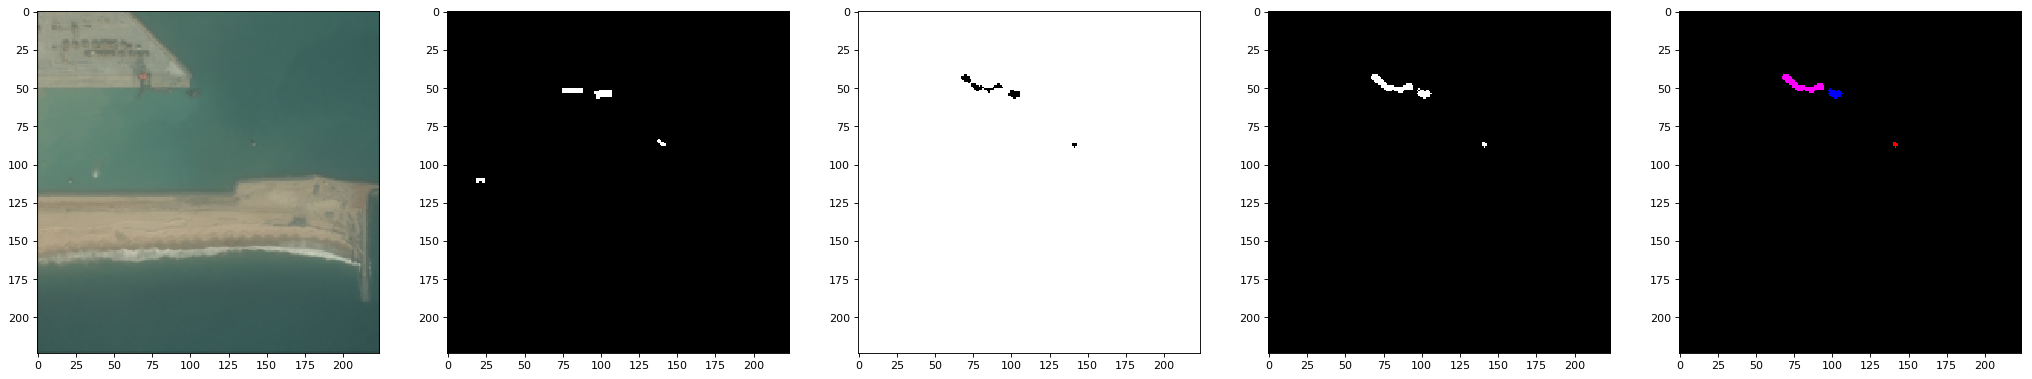

In [125]:
for i in range(1, 2):
    infer_and_compare_result(model, sd[i])

In [35]:
#model.apply(weights_init)

In [119]:


surface = np.zeros((image_width, image_height, 3), np.uint8)
image1, image2 = infer(model, sd[45])
image = np.array(image2)
_, contours, _ = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

for index, contour in enumerate(contours):
    colours = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 0, 255), (0, 255, 255), (255, 255, 0)]
    colour = colours[index % 6]
    cv2.drawContours(surface, [contour], -1, colour, -1)


In [126]:
image1.width

224

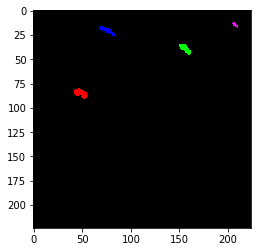

In [120]:
plt.imshow(surface)